# Week 7 - HMM Implementation

In [1]:
%matplotlib inline
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

#### (1) Load the data from HMMobs.csv and plot the observations.

You'll need to figure out an time axis vector for the data (it was recorded starting from midnight at even intervals over 24 hours).

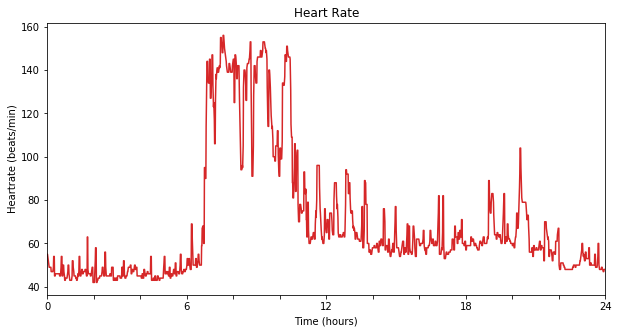

In [2]:
hr = np.loadtxt("wk7_HR.csv")
    
def plt_hr(figsize = (10,5)):
    t = np.linspace(0, 24, num = len(hr))
    plt.subplots(figsize = figsize)
    plt.xlim(0, 24)
    plt.xticks(np.linspace(0,24, num = 13), [0,"","",6,"","",12,"","",18,"","",24])
    plt.title('Heart Rate')
    plt.ylabel('Heartrate (beats/min)')
    plt.xlabel('Time (hours)');
    return t

t = plt_hr();
plt.plot(t, hr, color = 'tab:red');

#### (2) Do you see regions where there might be differences in behavior?

The person monitored seems to wake around 7 am, is most active in the morning until 11 am, and goes to sleep around 10 pm. This is based on the variation in heartrate throughout the day; I expect a higher heartrate to be correlated with being awake and an even higher heartrate to be associated with being more active.

#### (3) Based on when you might expect someone would be asleep, plot the histogram of resting heart rate values.

Given the shape of this distribution, do you think any transformation of the data would be helpful?

P-value w/ log transformation: 5.919709e-13
P-value w/o log transformation: 4.973799e-14


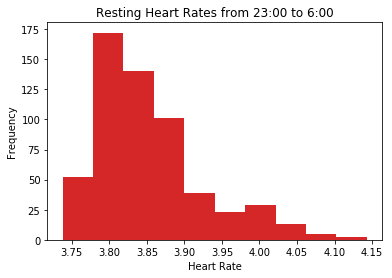

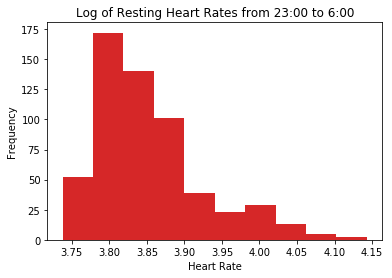

In [3]:
from scipy.stats import kstest, zscore

#Sleeping hours in 24 hour time
t_wake = 6
t_sleep = 23

night = np.vstack(hr[round(t_sleep/24*len(hr)) : len(hr)])
morning = np.vstack(hr[0: round(t_wake/24*len(hr))])
sleep = np.squeeze(np.vstack((night, morning)))

def plt_hist(log_ = False):
    plt.subplots()
    if log_ is False:
        plt.hist(np.log(sleep), color = "tab:red")
        plt.title(f'Resting Heart Rates from {t_sleep}:00 to {t_wake}:00')
    elif log_ is True:
        plt.hist(np.log(sleep), color = "tab:red")
        plt.title(f'Log of Resting Heart Rates from {t_sleep}:00 to {t_wake}:00')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequency')

plt_hist()
plt_hist(log_ = True);
print('P-value w/ log transformation: %e' %kstest(zscore(np.log(sleep)), 'norm')[1])
print('P-value w/o log transformation: %e' %kstest(zscore(sleep), 'norm')[1])

The distribution is skewed right. Using a KS test shows that the distribution is not normal, as the p-value is less than 0.05; Gaussian HMM assumes a normal distribution. By using just the sleep state, our emissions should be normally distributed, but they aren't. By taking the log of the distribution, the p-value increases slightly, indicating that the log of the distribution is slightly more normal than the original. Still, this distribution does not satisfy the assumption of this Gaussian HMM class that emissions have a normal distribution. This will make the data harder to fit a model to.

#### (4) One way to deal with noisy data is to use a moving average. Plot the moving average of the data for two different windows. How does this help visualize the data? What is lost using this approach?

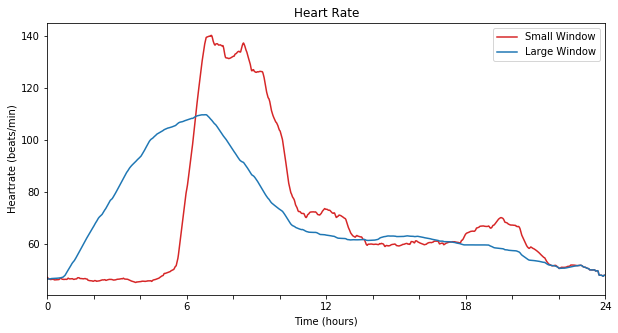

In [4]:
meanWindow = np.zeros_like(hr)
smallWindow = 100
largeWindow = 500
smallAverage = np.zeros_like(hr)
largeAverage = np.zeros_like(hr)

# Fill in average of window for each point
for i, heartrate in enumerate(hr):
    smallAverage[i] = np.mean(hr[i : i + smallWindow])
    largeAverage[i] = np.mean(hr[i : i + largeWindow])

# Plot
t = plt_hr()
plt.plot(t, smallAverage, color = 'tab:red')
plt.plot(t, largeAverage, color = 'tab:blue')
leg = ['Small Window', 'Large Window']
plt.legend(leg);

Using a moving window reduces the noise in the data, smoothing it to make it easier to see trends without the numerous peaks. However, using a window that is too large can lose important data since averages span multiple patient states. A large window cuts out important definition.

#### (5) We're going to fit an HMM model to this data with three underlying states. This involves three sets of parameters about the model—describe each briefly.

The three underlying states are 'asleep', 'awake', and 'active'. These are described by three parameters, the starting, transition, and emissions matrices. The starting contains the initial probabilities of each state. This is similar to the initial guess required for non-linear least squares. There is one probability for each state. The transition probabilities are the chance of changing from any given state to each of the other states. There will be (# of states) squared transition probabilities. The emissions are the distribution of outcomes for each state. The histogram in #3 represents the emissions for the 'asleep' state.

#### (6) Fit an HMM model with Gaussian emissions to the data. Use any transformations as necessary.

How does the model respond to rapid state changes? Overlay the raw measurements and HMM state over time.

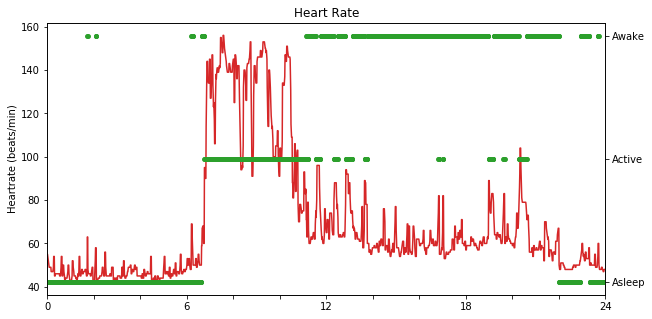

In [33]:
np.random.seed(4)
model = GaussianHMM(n_components = 3)
hr_log = np.log(hr) #use log transformation
hr_reshape = hr_log.reshape(-1,1)
model.startprob_ = np.array([1.0, 0.0, 0.0])
model.fit(hr_reshape)

fig, ax1 = plt.subplots(figsize = (10,5))
t = np.linspace(0, 24, num = len(hr))
ax1.plot(t, hr, color = 'tab:red')
plt.ylabel('Heartrate (beats/min)')
ax2 = ax1.twinx()
plt.xlim(0, 24)
plt.xticks(np.linspace(0,24, num = 13), [0,"","",6,"","",12,"","",18,"","",24])
plt.title('Heart Rate')

ax2.scatter(t,model.decode(hr_reshape)[1], color = 'tab:green', s = 15)
plt.xlabel('Time (hours)')
plt.yticks([0,1,2], ["Asleep", "Active", "Awake"]);

The prediction responds to rapid state changes by predicting a few timepoints as changing before more confidently predicting the new state. For example, when going from 'asleep' to 'active' around 7:00, the model first predicts 'awake' for a few timepoints before moving to and remaining at 'active'. Similarly, when going from 'awake' to 'asleep' around 22:00, the model first wavers between 'awake' and 'asleep' before remaining solidly at 'asleep' for the remainder of the night.

#### (7) From the HMM model determine, with a confidence interval, when the patient woke up in the morning. Compare this prediction to the data you obtain with the moving average.

Hint: `model.predict_proba(X)` can give you the probability of being in each state at each time point.

Window size: 6, Waking time: 6.22
Window size: 7, Waking time: 6.23
Window size: 8, Waking time: 6.22
Window size: 9, Waking time: 6.22
Window size: 10, Waking time: 6.65
Window size: 11, Waking time: 6.67
Window size: 12, Waking time: 6.67
Window size: 13, Waking time: 6.65
Window size: 14, Waking time: 6.67
Window size: 15, Waking time: 6.67
Window size: 16, Waking time: 6.67


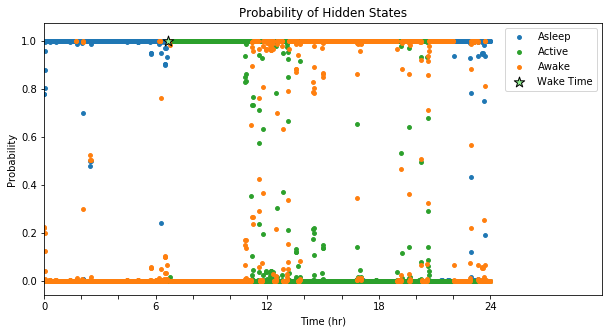

In [32]:
# Get probabilities of each state for all timepoints
p_asleep = model.predict_proba(hr_reshape)[:,0]
p_active = model.predict_proba(hr_reshape)[:,1]
p_awake = model.predict_proba(hr_reshape)[:,2]

# Find waking time
threshold = 0.6 # threshold probability for state change (arbitrary and not very specific)

for window in range(6,17): # time points to average
    i = 0
    awake = False
    while awake is False:
        i += 1 # step through timepoints    
        if np.mean(p_asleep[i:i+window]) < 1 - threshold and np.mean(p_awake[i:i+window]) > threshold:
            #if p_asleep[i] < threshold and p_active[i] > threshold: # could use active since it happens almost instantly after waking
            awake = True
            t_wake = i+round(window/2)
            print('Window size: %i, Waking time: %.2f' %(window, t[t_wake]))

# Plot probabilities of each state at each timepoint
markersize = 15
plt.figure(figsize = (10,5))
plt.scatter(t, p_asleep, s = markersize, color = 'tab:blue')
plt.scatter(t, p_active, s = markersize, color = 'tab:green')
plt.scatter(t, p_awake, s = markersize, color = 'tab:orange')

plt.scatter(t[t_wake], p_awake[t_wake], s = 120, marker = '*', color = 'lightgreen', edgecolor = 'k') # plot waking time

plt.xlim(0, 30)
plt.xticks(np.linspace(0,24, num = 13), [0,"","",6,"","",12,"","",18,"","",24])
leg = ['Asleep', 'Active', 'Awake', 'Wake Time']
plt.legend(leg)
plt.ylabel('Probability')
plt.xlabel('Time (hr)');
plt.title('Probability of Hidden States');

This person woke between 6:13 and 6:40 AM. This time was calculated using a method similar to the moving average method. At each time point, the probabilities of being asleep or awake at that timepoint were averaged with the 6 to 16 following points. When the average probability of being awake exceeded an arbitrary threshold, the middle of the averaged time points was stored as the 'waking' time. The averaging method was used to prevent single state changes in early morning from being labeled the waking time. Taking a range of window sizes from 6 to 17, we find a confidence interval for the waking time of half an hour starting at 6:13 AM.

The waking time in the moving average of problem 4 appears to be around 6 AM. The smoothed plot makes it appear that the person woke earlier than estimated by the probabilities in problem 7; this is  becuase of the influence of the post-waking points included in the averages for time steps before actually waking. This is exactly what smooths the graph, but also makes it more difficult to determine exactly when the person woke.

#### (8) Describe one form of other information you could use from a smart watch to make a more accurate determination of the user's state.

How would you use that in your model?

We could use an accelerometer to help determine a user's state. If the user moves a lot, they are likely awake. We could possibly have 2 emissions probability distributions for each state. One distribution for heartrate and one for accelerometer data.